<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/UNet_full_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# now we can see Drive as local

Mounted at /content/gdrive


In [2]:
import os
from PIL import Image
from numpy import asarray
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 as cv2
import sys

In [3]:
%tensorflow_version 2
%load_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# load every image into memory
ORIG = '/content/gdrive/MyDrive/images/rgb_orig_rand'
TARGET = '/content/gdrive/MyDrive/images/rgb_ss'

n = 100
x_train = []
y_train = []

for i in range(n):
  if os.path.isfile(os.path.join(ORIG, f'{i}.png')):
    img = Image.open(os.path.join(ORIG, f'{i}.png'))
    data = asarray(img)
    x_train.append(data)
    img = Image.open(os.path.join(TARGET, f'{i}_seg.png'))
    data = asarray(img)
    y_train.append(data)

drive.flush_and_unmount()

In [5]:
x_train = [np.delete(elem, [False, False, False, True], axis=2) for elem in x_train]
y_train = [np.delete(elem, [False, False, False, True], axis=2) for elem in y_train]

In [6]:
#x_train = [i.astype('float32') / 255. for i in x_train]
print(len(x_train))

85


In [7]:
x_test = x_train[60:]
x_train = x_train[:60]
y_test = y_train[60:]
y_train = y_train[:60]

#print(x_train[0])
x_train = np.array(x_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [8]:
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_CHANNELS = 3

length = y_train.shape[0]

In [9]:
Y_train = []
for i in range(length):
  img = y_train[i]
  # remove magenta
  img[np.all(img == np.array([255,0,254]), axis=-1)] = np.array([0,0,0])
  # replace yellow with white
  img[np.all(img == np.array([255,255,0]), axis=-1)] = np.array([255,255,255])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )
  img=img[:,:,:1]
  np.squeeze(img)
  img = img/255.
  Y_train.append(img)      #.astype('float32') / 255.

print(Y_train[0].shape)
y_train = np.array(Y_train)
#plt.imshow(Image.fromarray(y_train[0]))


(240, 320, 1)


In [10]:
BATCH_SIZE = 2
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [11]:
s = tf.keras.layers.Lambda(lambda x:x /255)(inputs)

#ENCODER

(320,240,3) --> (160,120,16)

In [12]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

(160,120,16) --> (80,60,32)

In [13]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

(80,60,32) --> (40,30,64)

In [14]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

(40,30,64) --> (20,15,128)

In [15]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

#BOTTOM

In [16]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c5)

#DECODER

In [17]:
u6 = tf.keras.layers.Convolution2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4]) #mergre with old layer
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c6)

In [18]:
u7 = tf.keras.layers.Convolution2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])  #mergre with old layer
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c7)

In [19]:
u8 = tf.keras.layers.Convolution2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])  #mergre with old layer
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c8)

In [20]:
u9 = tf.keras.layers.Convolution2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])  #mergre with old layer
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c9)

In [21]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)

Checking model correctness

In [22]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

checkpointer = tf.keras.callbacks.ModelCheckpoint('duckie_street.h5', verbose=1, save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(x_train,y_train, validation_split=0.1, batch_size = BATCH_SIZE, epochs=100, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [23]:
import random
import matplotlib.pyplot

seed = 42
np.random.seed = seed

1/1 [==============================] - 4s 4s/step


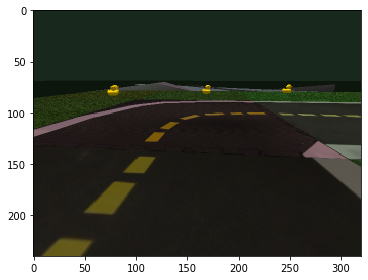

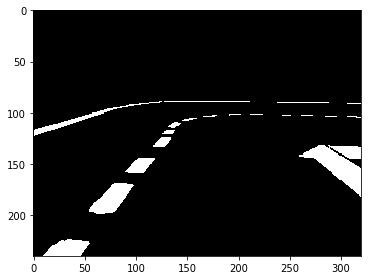

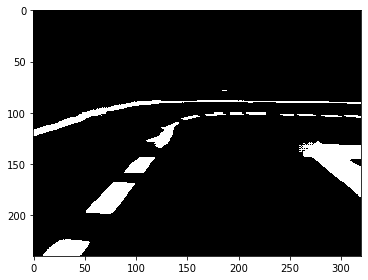

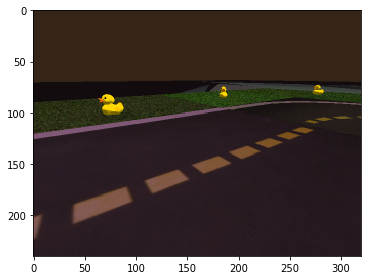

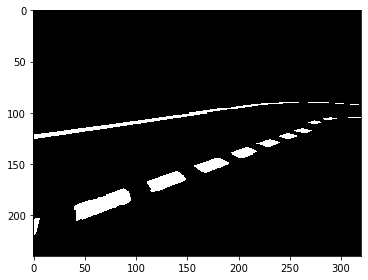

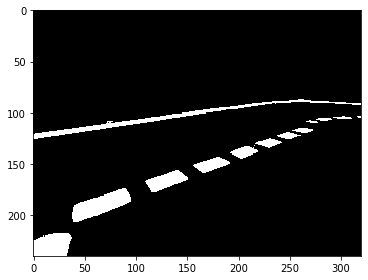

In [24]:
idx = random.randint(0, len(x_train))

preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(x_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


#Sanity check on random training samples


ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()

im=np.squeeze(y_train[ix])
indices = im.astype(np.uint8)  #convert to an unsigned byte
indices*=255
imshow(indices)

plt.show()

im3 = np.squeeze(preds_train_t[ix])
im3*=255
imshow(im3) 
plt.show()



#sanity on validation ex

ix =random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix])
plt.show()

im2 = np.squeeze(Y_train[int(y_train.shape[0]*0.9):][ix])
indices = im2.astype(np.uint8)
indices*=255
imshow(indices) 
plt.show()


im3 = np.squeeze(preds_val_t[ix])
im3*=255
imshow(im3) 
plt.show()

In [25]:
model.save('segmentation_model')

In [26]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
!cp -r segmentation_model /content/gdrive/MyDrive/